<a href="https://colab.research.google.com/github/MSaber9/Thesis2021/blob/main/Anomaly_detection_minmax_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls

sample_data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import pickle
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from glob import iglob


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Loading benign traffic data...")
#All benign
#df = pd.concat((pd.read_csv(f) for f in iglob('/content/drive/My Drive/Colab Notebooks/DataIoT/*.benign.csv' , recursive= True)), ignore_index=True)

# One benign traffic [1.Danmimi_Doorbell]
df_bening = pd.concat((pd.read_csv(f) for f in iglob('/content/drive/My Drive/Colab Notebooks/DataIoT/1.benign.csv' , recursive= True)), ignore_index=True)

Loading benign traffic data...


In [ ]:
df_bening.shape

(49548, 115)

There should have been 49,548 instances

In [ ]:
#df_bening = (df_bening - df_bening.mean()) / df_bening.std()
#df_bening = scale(df_bening)

In [ ]:
scaler = MinMaxScaler()
df_bening = scaler.fit_transform(df_bening)

In [ ]:
x_train, x_opt, x_test = np.split(df_bening, [int((1/3)*len(df_bening)), int((2/3)*len(df_bening))])

In [ ]:
print(x_train.shape)
print(x_opt.shape)
print(x_test.shape)

(16516, 115)
(16516, 115)
(16516, 115)


In [ ]:
nb_epoch = 800
input_dim = x_train.shape[1]
learning_rate = 0.012

autoencoder = Sequential()
autoencoder.add(Dense(int(0.75 * input_dim), activation="tanh", input_dim=input_dim))
autoencoder.add(Dense(int(0.5 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.33 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.25 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.33 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.5 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.75 * input_dim), activation="tanh"))
autoencoder.add(Dense(input_dim))

In [ ]:
autoencoder.compile(loss='mean_squared_error',
                    optimizer='sgd')

cp = ModelCheckpoint(filepath="autoencoder_traffic_minmax.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(x_train, x_train,
                    epochs=nb_epoch,
                    validation_data=(x_opt, x_opt),
                    verbose=1,
                    callbacks=[cp, tb]).history

Epoch 1/800
517/517 [==============================] - 2s 3ms/step - loss: 0.0436 - val_loss: 0.0267
Epoch 2/800
517/517 [==============================] - 1s 3ms/step - loss: 0.0244 - val_loss: 0.0176
Epoch 3/800
517/517 [==============================] - 1s 3ms/step - loss: 0.0163 - val_loss: 0.0118
Epoch 4/800
517/517 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0082
Epoch 5/800
517/517 [==============================] - 1s 3ms/step - loss: 0.0079 - val_loss: 0.0062
Epoch 6/800
517/517 [==============================] - 1s 3ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 7/800
517/517 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 8/800
517/517 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 9/800
517/517 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 10/800
517/517 [==============================] - 1s 2ms/step - loss: 0.0038 - val_lo

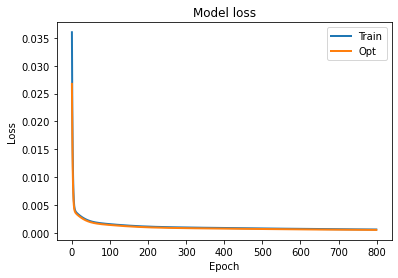

In [ ]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Opt')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
x_opt_predictions = autoencoder.predict(x_opt)

In [ ]:
mse = np.mean(np.power(x_opt - x_opt_predictions, 2), axis=1)

In [ ]:
mse.shape

(16516,)

In [ ]:
mse

array([5.49741044e-04, 9.07924327e-05, 7.92762959e-05, ...,
       4.37087029e-05, 2.29537834e-05, 4.92575488e-04])

In [ ]:
print(mse.mean())
print(mse.min())
print(mse.max())
print(mse.std())

0.0005102217036356298
6.165446767868429e-06
0.15425338181782133
0.003912119466902127


In [ ]:
tr = mse.mean() + mse.std()
tr

0.004422341170537756

Claimed tr for this dataset is 0.042

In [ ]:
x_test_predictions = autoencoder.predict(x_test)

In [ ]:
mse_test = np.mean(np.power(x_test - x_test_predictions, 2), axis=1)
mse_test.shape

(16516,)

In [ ]:
over_tr = mse_test > tr
false_positives = sum(over_tr)
print(false_positives)
fpr = false_positives / mse_test.shape[0]
print(fpr)

240
0.01453136352627755


Claimed window size is 82

In [ ]:
false_alarms = 0
w = 82
for i in range(0, len(over_tr) - w):
  fp = sum(over_tr[i:i+w])
  if fp/2 > w:
    false_alarms = false_alarms + 1
    
print('False alarms %d' % false_alarms)
    

False alarms 0
